# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1</center>
## <center>Checkpoint 2 : Árbol de decisión</center> 

# Consigna


1.   Construir árboles de decisión y optimizar sus hiperparámetros mediante k-fold Cross Validation para obtener la mejor performance. **¿Cuántos folds utilizaron?¿Qué métrica consideran adecuada para buscar los parámetros?**
2.   Graficar el árbol de decisión con mejor performance encontrado en el punto
anterior. Si es muy extenso mostrar una porción representativa.
3.   **Analizar el árbol de decisión seleccionado describiendo los atributos elegidos, y decisiones evaluadas (explicar las primeras reglas obtenidas).**
4.   Evaluar la performance del modelo en entrenamiento y validación, explicar todas
las métricas y mostrar la matriz de confusión.
5.   Generar predicciones con el conjunto de test y realizar los submits
correspondientes en la competencia de Kaggle.

# Inicializacion de entorno

## Librerías

In [2]:
!pip install dtreeviz


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from datetime import datetime
import time

#Preprocesamiento
from sklearn.preprocessing import (
    KBinsDiscretizer,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,

)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score,
    cross_validate,
)

#modelos
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegressionCV,
    LogisticRegression
)
from sklearn.tree import (
    DecisionTreeClassifier, 
    export_graphviz
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

#ensambles 
from sklearn.ensemble import (
    IsolationForest, 
    RandomForestClassifier, 
    GradientBoostingRegressor,
    StackingClassifier,
    RandomForestClassifier,
    VotingClassifier
)
import xgboost as xgb
from sklearn.pipeline import Pipeline

#metricas
from sklearn.metrics import(
    confusion_matrix,
    classification_report,
    make_scorer,
    recall_score, 
    accuracy_score,
    f1_score,
    precision_score
)
from collections import defaultdict

#Visualización
import dtreeviz
import plotly.express as px
import plotly.graph_objects as go
from sklearn import tree

#guardado 
from google.colab import files
import pickle

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

## Funciones

### Métricas

In [4]:
def metricas_modelo(test, pred, title="Matriz de confusión y métricas para el modelo"):
  #Calculo las métricas en el conjunto de evaluación
  accuracy=accuracy_score(test, pred)
  recall=recall_score(test, pred)
  f1=f1_score(test, pred)
  precision=precision_score(test, pred)

  metrics=[[str(round(accuracy,5)), str(round(recall,5)), str(round(precision,5)), str(round(f1,5))]]
  labels=['Accuracy', 'Recall', 'Precision', 'F1']
  
  matriz=confusion_matrix(test, pred)
  plt.title(title)
  t = plt.table(cellText=metrics,
            colLabels=labels,
            bbox=(1.5, .1, 0.75, 0.75))
  t.auto_set_font_size(False)
  t.set_fontsize(11)


  #Grafico la matriz de confusión
  sns.heatmap(matriz,cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [5]:
def metricas_cv(model, t=None):
  time_format = time.strftime("%M:%S", time.gmtime(round(t)))
  print("Resultados del Cross Validation")
  print("_______________________________")
  #Mejor métrica
  print("Tiempo transcurrido: ", time_format, " minutos")
  #Mejores hiperparametros
  print("Mejores hiperparametros: ", model.best_params_)
  #Mejor métrica
  print("Mejor métrica F1: ",model.best_score_)

In [6]:
#Funcion para evaluar los modelos 5fold -CV (repite 2 veces)
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

### Gráficos

In [7]:
plt.style.use('ggplot')

In [8]:
#Funcion para plotear a performance
def plot_results(model_scores, name):
    
    model_names = list(model_scores.keys())
    results = [model_scores[model] for model in model_names]
    fig = go.Figure()
    for model, result in zip(model_names, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance of Different Models Using 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

### Train

In [9]:
def Randomized_Cross_Validation(x_data, y_data, classifier, parameters, folds=5, iterations=10):
    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    model_rand = RandomizedSearchCV(estimator=classifier, 
                                    param_distributions = parameters, 
                                    scoring=scorer_fn, 
                                    cv=kfoldcv, 
                                    n_iter=iterations) 

    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_rand.fit(x_data, y_data)
    t_final = time.perf_counter()

    #Se muestran las métricas más relevantes
    metricas_cv(model_rand, t_final-t_inicio)

    return model_rand.best_estimator_

In [10]:
def Grid_Cross_Validation(x_data, y_data, classifier, parameters, folds=5):

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(sk.metrics.f1_score)

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)
   
    model_grid = GridSearchCV(estimator=classifier, param_grid=parameters, scoring=scorer_fn, cv=kfoldcv, n_jobs=-1)
    
    #Se entrena el modelo tomando el tiempo que tarda
    t_inicio = time.perf_counter()
    model_grid.fit(x_data, y_data)
    t_final = time.perf_counter()

    metricas_cv(model_grid, t_final-t_inicio)

    return model_grid.best_estimator_

In [11]:
def make_prediction(model, x_data, y_data):
    #Predicción
    y_pred = model.predict(x_data)

    metricas_modelo(y_data, y_pred)


La métricas para evaluar el rendimiento de un modelo se calculan comparando los valores predichos frente a los reales en un conjunto de testeo, es así que surgen diferentes valores:

*   **Matriz de confusión**:


|            | predicted    |            |            |
|:----------:|:------------:|:----------:|:----------:|
|            |              |      0     |       1    |
| real       |0             | TN         | FP         |
|            |1             | FN         | TP         |

**TN**: True Negative; **FN**: False Negative; **FP**: False Positive; **TP**: True Positive



---


*   **Precisión** (precision):
    \begin{align}
        precision=\frac{TP}{TP+FP}
    \end{align}

    La *precisión* indica que cuanto más se acerca a 1, menos falsos positivos tuvo y por lo tanto todos las predicciones sobre la positiva fueron correctas. Esta métrica valora la calidad del modelo.


---


*   **Exhaustividad** (recall):
    \begin{align}
        recall=\frac{TP}{TP+FN}
    \end{align}

    Si el *exhaustividad* se acerca a 1, quiere decir que no se quedó ningún negativo verdadero afuera. Esta métrica valora la cantidad de valores que pueden identificar del modelo. 


---


*   **F1**:
    \begin{align}
        F1=2.\frac{precision.recall}{precision+recall}
    \end{align}

    *F1* se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de ambas métricas.


---


*   **Exactitud** (accuracy):
\begin{align}
    accuracy=\frac{TP+TN}{TP++TN+FP+FN}
\end{align}

  La *exactitud* indica cual es el porcentaje de aciertos del modelo. Sin embargo no brinda mucha información sobre cómo se distribuyen los valores.

    

## Datasets

In [12]:
db_train_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/processed/hotels_train.csv'
db_test_url = 'https://raw.githubusercontent.com/FranGuti/7506R-1C2023-GRUPO34/main/Datasets/processed/hotels_test.csv'
df_train = pd.read_csv(db_train_url)
df_test_submission = pd.read_csv(db_test_url)

In [13]:
df_work_train = df_train.copy()
df_work_test_submission = df_test_submission.copy()

## Variables 

In [14]:
columnas_cualitativas = [
    "hotel",
    "meal",
    "market_segment",
    "distribution_channel",
    "deposit_type",
    "customer_type",
]


columnas_discretas = [
    "lead_time",
    "arrival_date_year",
    "arrival_date_week_number",
    "arrival_date_day_of_month",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "adults",
    "children",
    "babies",
    "booking_changes",
    "days_in_waiting_list",
    "total_of_special_requests",
    "previous_cancellations",
    "previous_bookings_not_canceled",
    "required_car_parking_spaces"
]

columnas_continuas = [
    "adr",
]

columnas_cuasicuantitativas = [
    "arrival_date_month",
    "is_repeated_guest",    
    "reserved_room_type",
    "assigned_room_type",
    "misassigned_room",
    "country_prt",
    "required_car_parking_spaces",
    "agent",
    "company",
     "id"
]

# Preprocesamiento del dataframe

## Limpieza de columnas irrelevantes

Se eliminan columnas nulas o irrelevantes detectadas en el analisis exploratorio

In [15]:
# Id es irrelevante
# reservation_status_date delata el resultado del target y
# assigned_room_type y reserved_room_type, consideramos que tiene su información relevante condensada en misassigned_room
columnas_para_eliminar = ['id', 'assigned_room_type', 'reserved_room_type']

df_work_train.drop(columnas_para_eliminar, axis='columns', inplace=True)
df_work_test_submission.drop(columnas_para_eliminar, axis='columns', inplace=True)

## Label encoding

Se encodean con Label encoding `arrival_date_month` ya que se puede establecer un orden entre los meses

In [16]:
columns_to_encode = ['arrival_date_month']

le = LabelEncoder()
for column in columns_to_encode:  
  df_work_train[column] = le.fit_transform(df_work_train[column].astype(str))
  df_work_test_submission[column] = le.fit_transform(df_work_test_submission[column].astype(str))


In [17]:
df_work_train[columns_to_encode]

,arrival_date_month
0,11
1,10
2,10
3,2
4,7
...,...
55381,4
55382,11
55383,8
55384,10


## Normalización

Para la normalización de las variables cuantitativas decidimos realizar la normalización standard por sobre la MinMax, ya que la primera conserva la distribución y por ende va a tener una mejor performance para los modelos.

### Variables Continuas

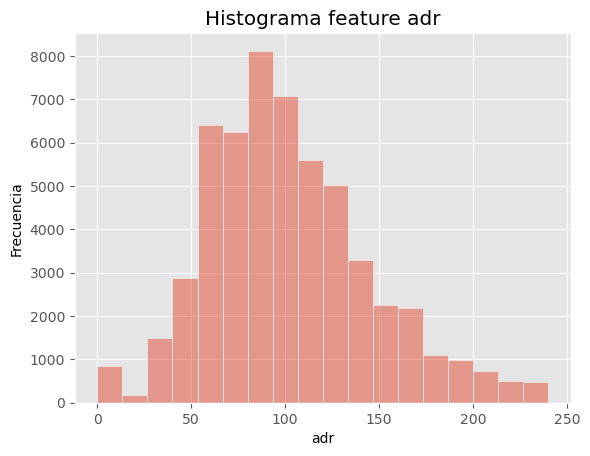

In [18]:
sns.histplot(data=df_work_train['adr'], alpha = 0.5, bins=18).set(title="Histograma feature adr",xlabel="adr",ylabel="Frecuencia")
plt.show()

Se normaliza la única variable cuantiativa continua `adr` 

In [19]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler() 

adr_standard = standard_scaler.fit_transform(df_work_train['adr'].to_frame())
df_work_train['adr'] = adr_standard

Como la normalización no debería modificar la distribución, graficamos un histograma de `adr` para corroborarlo

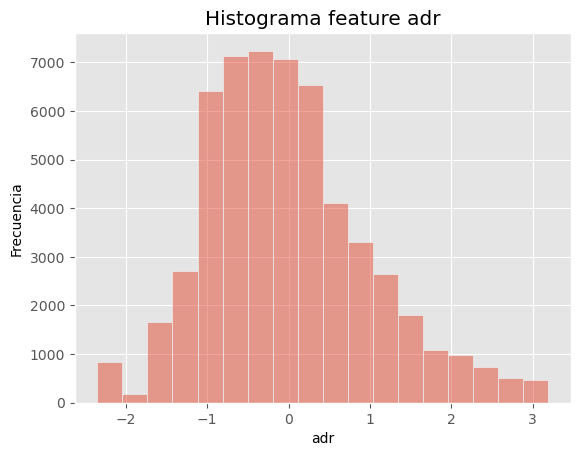

In [20]:
sns_hist=sns.histplot(data=df_work_train['adr'], alpha = 0.5, bins=18).set(title="Histograma feature adr",xlabel="adr",ylabel="Frecuencia")
plt.show()

### Variables Discretas

In [21]:
def standarizar_variable(data, columna):
  var_standard = standard_scaler.fit_transform(data[columna].to_frame())
  data[columna] = var_standard

for col in columnas_discretas:
  standarizar_variable(df_work_train, col)

In [22]:
df_work_train[columnas_discretas].head(5)

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,total_of_special_requests,previous_cancellations,previous_bookings_not_canceled,required_car_parking_spaces
0,-0.565599,-0.204779,0.725512,-1.221214,0.044092,-0.281037,-1.490227,-0.254429,-0.076731,-0.35192,0.0,0.595154,-0.103708,0.0,-0.219875
1,-1.025834,-1.597447,1.243920,1.737302,-0.957160,-0.803967,0.204349,-0.254429,-0.076731,-0.35192,0.0,-0.693830,-0.103708,0.0,4.511280
2,-0.811058,-0.204779,1.095803,-0.310902,-0.957160,-0.803967,0.204349,4.896088,-0.076731,-0.35192,0.0,1.884138,-0.103708,0.0,-0.219875
3,-0.800830,-0.204779,1.762327,-0.424691,1.045343,1.287753,0.204349,-0.254429,-0.076731,-0.35192,0.0,-0.693830,-0.103708,0.0,-0.219875
4,-0.003090,1.187889,-1.125942,0.371833,1.045343,1.287753,0.204349,-0.254429,-0.076731,-0.35192,0.0,0.595154,-0.103708,0.0,-0.219875


In [23]:
for col in columnas_discretas+columnas_continuas:
  standarizar_variable(df_work_test_submission, col)

## One Hot encoding

Para aquellas **variables cualitativas de texto** que presentan los mismos valores tanto en el train como en el test, utitilizamos *One Hot Encoding* para que puedan ser procesadas por los modelos

In [24]:
columnas_dummies = [   
    "hotel",
    "deposit_type",
    "distribution_channel",
    "market_segment",
    "customer_type",
    "country_prt",
    'meal'
]

df_work_train = pd.get_dummies(df_work_train, columns=columnas_dummies, drop_first=True)
df_work_test_submission = pd.get_dummies(df_work_test_submission, columns=columnas_dummies, drop_first=True)

Se eliminan aquellas variables dummies que contienen informacion redundante

In [25]:
df_work_train.columns.size

41

## Separación en x e y

Separacion entre columnas de decision y de target

In [26]:
#Creo un dataset con los features que voy a usar para clasificar
x_work = df_work_train.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
y_work = df_work_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(x_work,
                                                    y_work, 
                                                    test_size=0.25,  #proporcion 75/25
                                                    random_state=2, #semilla
                                                    stratify=df_work_train['is_canceled'].values) 

x_test_submission = df_work_test_submission.copy()                                               

# Entrenamiento y Predicción

### Árbol sin optimizaciones

In [27]:
tree_model_basic = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 5, 
                                         min_samples_leaf=10) 
#Entrenamos el modelo
tree_basic = tree_model_basic.fit(X = x_train, y = y_train)

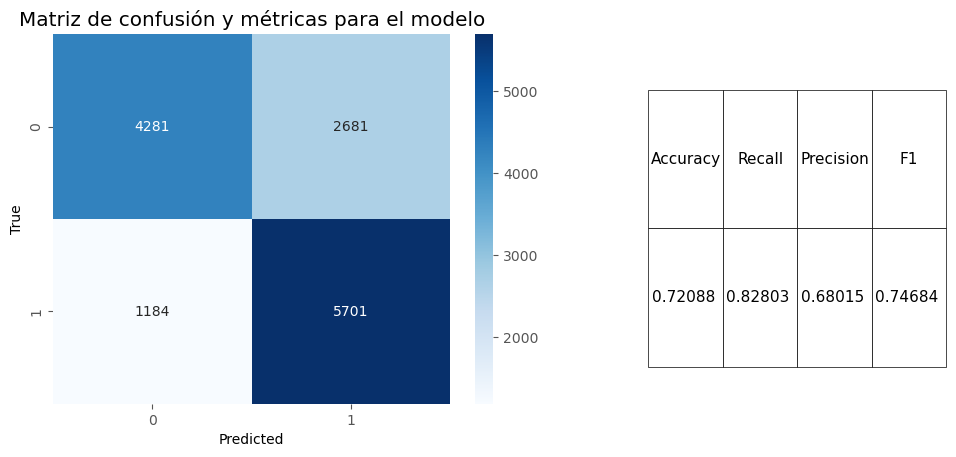

In [28]:
#Realizamos una predicción sobre el set de test
make_prediction(tree_basic, x_test, y_test)

### Árbol optimizado con CrossValidation

Buscamos los mejores hiperparámetros para el modelo mediante k-fold CrossValidation para obtener la mejor performance.

Decidimos buscar hiperparámetros que optimizaran accuracy ya que nos pareció la métrica más adecuada.

Realizamos 20 iteraciones para buscar los mejores hiperparámetros, y dividimos el dataset en 5 folds para el Cross Validation. Elegimos usar 5 ya que nos pareció que es una cantidad razonable de subconjuntos.


In [29]:
params = {
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": list(range(1, 10)),
    "ccp_alpha": np.linspace(0, 0.05, 20),
    "max_depth": list(range(1, 1000)),
    'random_state': [0]
}

base_tree = DecisionTreeClassifier()

best_tree = Randomized_Cross_Validation(x_train, y_train, base_tree, params, 10, 20)


Resultados del Cross Validation
_______________________________
Tiempo transcurrido:  00:34  minutos
Mejores hiperparametros:  {'random_state': 0, 'min_samples_leaf': 2, 'max_depth': 746, 'criterion': 'entropy', 'ccp_alpha': 0.005263157894736842}
Mejor métrica F1:  0.8253681928486503


Se hace una predicción con nuestro conjunto de test y se toman las métricas

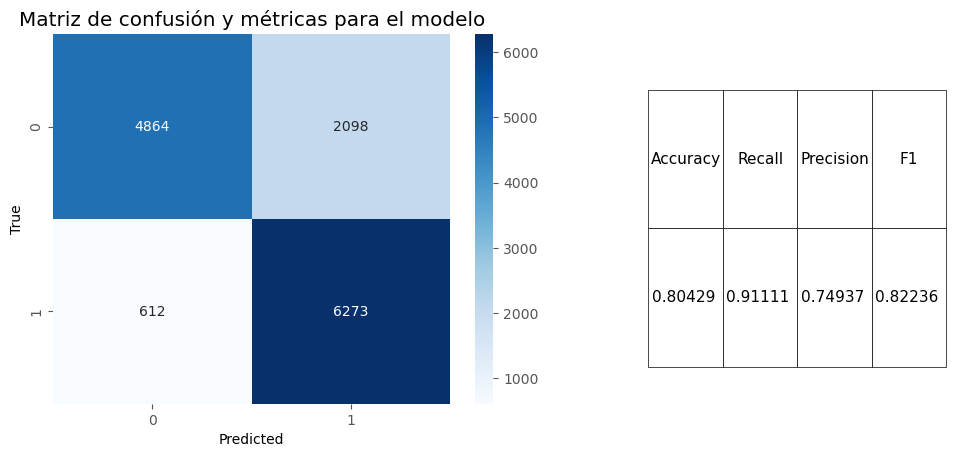

In [30]:
make_prediction(best_tree, x_test, y_test)

# Gráfico del modelo optimizado

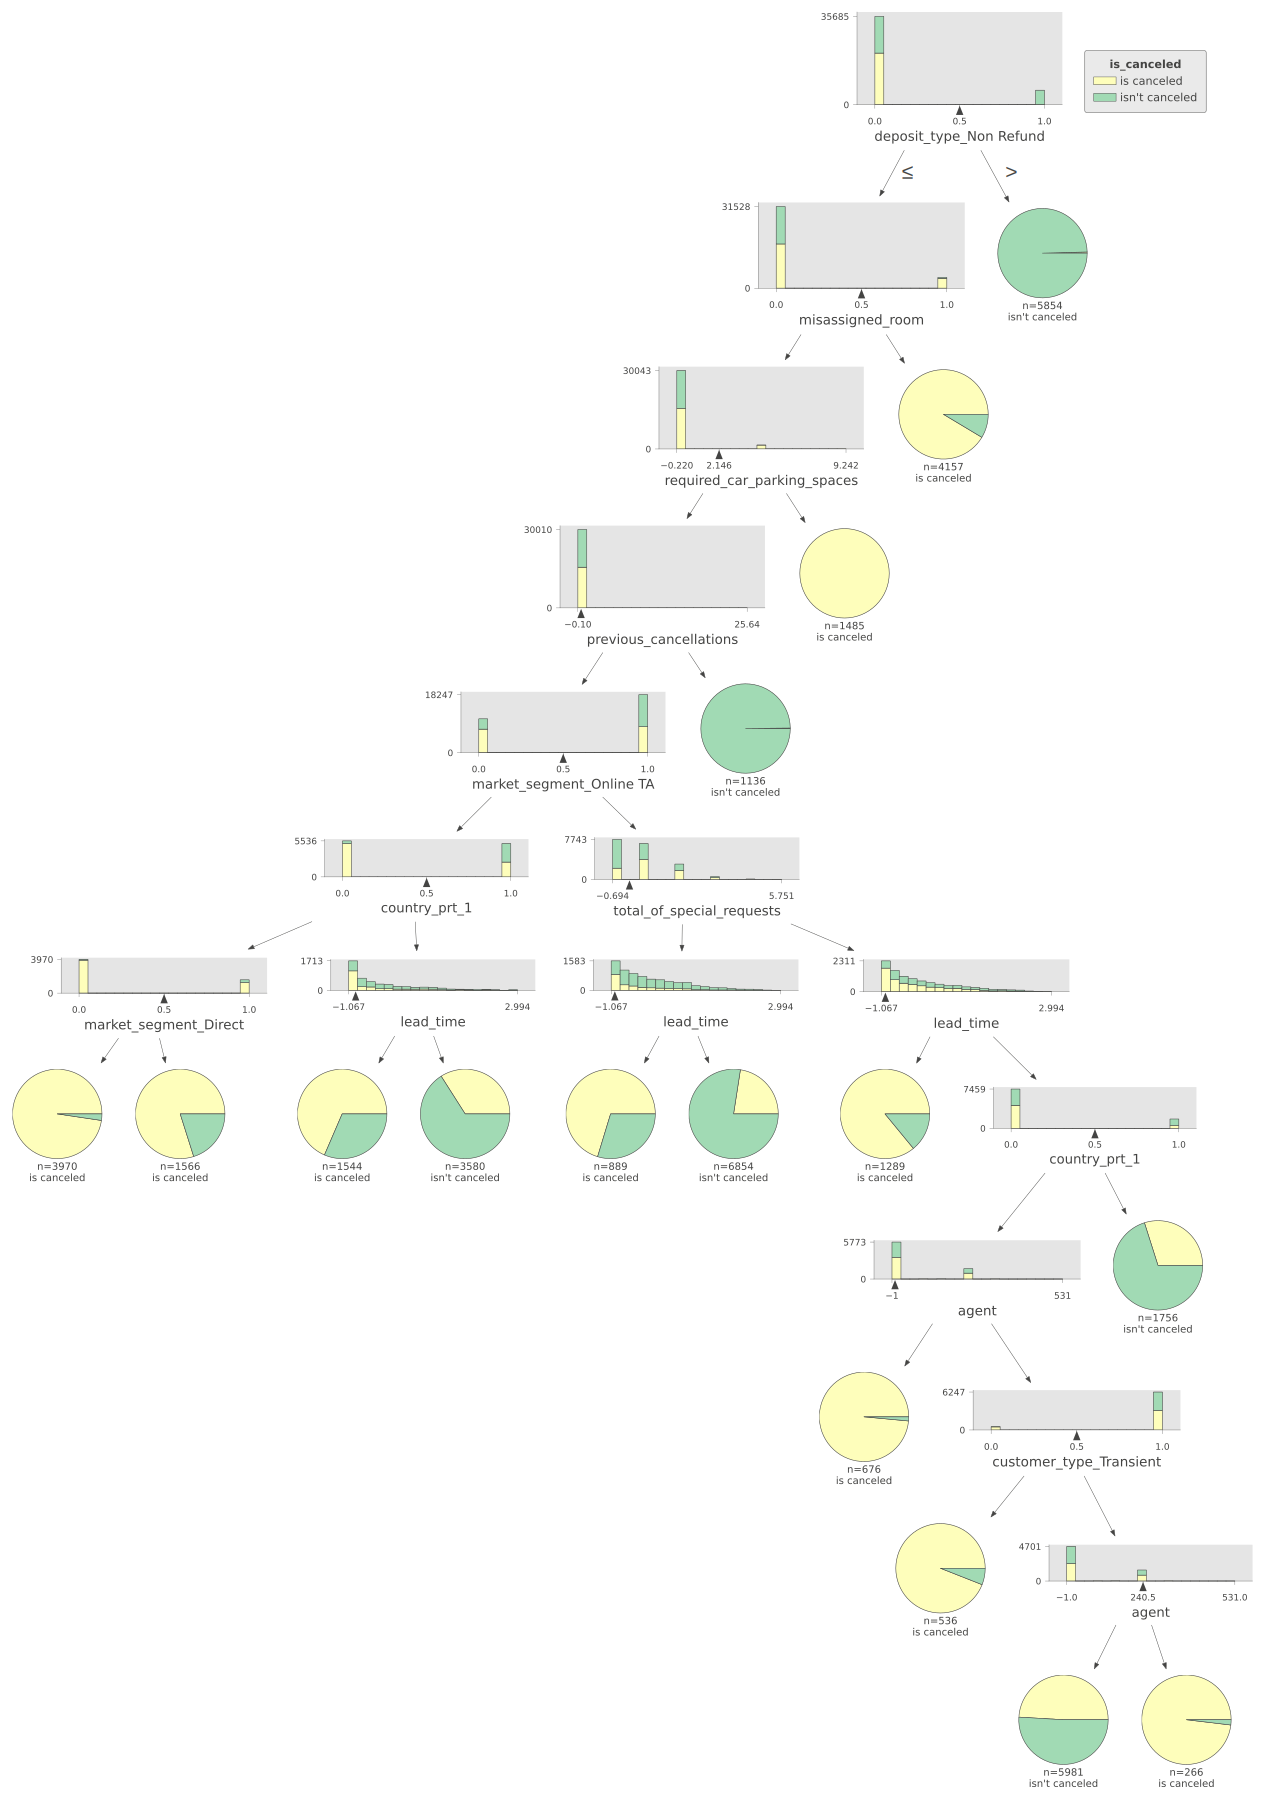

In [31]:
viz = dtreeviz.model(
    best_tree,
    x_train,
    y_train,
    class_names=["is canceled","isn't canceled"], 
    target_name='is_canceled',
    feature_names=x_train.columns.to_list(),
)

viz.view(scale=1.5)



Como podemos observar, el árbol primero pregunta si Non refun en deposit_type es menor que 0.5. Si esto se cumple, se generan dos ramas, una pregunta si misassigned_room es menor a 0.5 y si country es menor a 38.

Luego, se generan 4 subramas: en una se pregunta por los required_car_parking_spaces es menor a 0.5, en otra si la variable country es menor a 65.5, la otra si la variable arrival_date_week_number es menor a 22 y la última si en la variable customer_type aparece Transient-party menos de 0.5

Así sigue generando las ramas hasta que termina de clasificar todas las observaciones.


# Submission

Se realiza una prediccion a partir de las columnas de decision del dataframe de test

In [32]:
y_pred = best_tree.predict(x_test_submission)
df_submission = pd.DataFrame({"id": df_test_submission["id"], "is_canceled": y_pred})
df_submission

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1
...,...,...
26530,636ccded-66ad-4538-8006-c0b9f84c6256,0
26531,11e19741-bd28-4459-8ea3-184f1664000f,0
26532,36a4c7b0-d6b1-4528-93db-311be96ec1c6,1
26533,89c85fa5-2b3d-4131-844c-e151a65ca240,1


In [33]:
from google.colab import files

file_name = 'submission ' + datetime.now().strftime("%d-%m %H:%M:%S") + '.csv'
df_submission.to_csv(file_name, encoding = 'utf-8-sig', index=False) 
files.download(file_name)

KeyboardInterrupt: 